### Data Mining on Hospital Dataset

This notebook analyses hospital records of diabetic patients and predicts the possibilty of readmittance.

Thomas Binu tb6405, Chinmay Singh cks9089

### Imports

In [101]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.preprocessing import Imputer, StandardScaler
import matplotlib.patches as mpatches
from IPython.display import HTML
from operator import itemgetter
from sklearn.model_selection import cross_val_score
from scipy.stats import itemfreq
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
import matplotlib as mpl
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
import time


import pandas as pd
import numpy as np

%matplotlib inline

mpl.rcParams['figure.figsize'] = (10,10)

### Helper functions

In [102]:
# Basic graph plotting utility
def plot_basic_graph(x_list, y_list, x_label, y_label, best_x=None, best_y=None, symbol='r-'):
    fig, ax = plt.subplots()
    plt.plot(x_list, y_list, symbol)
    plt.plot(x_list, y_list, 'r*')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if best_x and best_y:
        plt.plot([best_x, best_x], [y_list[0], best_y], 'ms-')
        plt.plot([x_list[0], best_x], [best_y, best_y], 'ms-')
        plt.plot([best_x], [best_y], marker='o', markersize=10, color='blue')
    
    plt.show()
    
def plot_correlation_graph(df, column_name, target_column):
    
    # df.groupby(target_column)[column_name].hist(alpha=0.2, stacked=True, color=['red'])
    # df.plot(legend=True)
    # plt.legend()
    gb = df.groupby(target_column)
    gbs = [gb.get_group(x) for x in gb.groups]
    print(gbs)
    
def report_correlations(df):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.xcorr(x, y, usevlines=True, maxlags=50, normed=True, lw=2)
    ax1.grid(True)
    ax1.axhline(0, color='black', lw=2)
    
    ax.set_xticklabels(column_names)
    ax.set_yticklabels(column_names)
    plt.show()

def report_missing_values(df):
    
    attr_list = []
    missing_value_list = []
    for attr in attributes:
        missing_count = df[attr].isnull().sum()
        if missing_count > 0:
            attr_list.append(attr)
            missing_value_list.append(round(missing_count / len(df[attr]) * 100))
    
    fig, ax = plt.subplots()
    y_pos = np.arange(len(attr_list))
    plt.bar(y_pos, missing_value_list)
    plt.xticks(y_pos, attr_list)
    plt.ylabel('Percentage')
       
    plt.show()
    

def print_bold(text):
    display(Markdown("**{}**".format(text)))
    
def print_color(text, color='red'):
    display(HTML("<text style=color:{}>{}</text>".format(color, text)))


def display_confusion_matrix(target_test, target_predict):
    print_bold('Confusion Matrix')
    y_actu = pd.Series(target_test, name='Actual')
    y_pred = pd.Series(target_predict, name='Predicted')
    cm = pd.crosstab(y_actu, y_pred)
    print(cm)
    return cm
    
# Basic graph plotting utility
def plot_roc_curve(confusion_matrix_list, models, x_label, y_label, model_names=''):
    
    tpr_fpr_list = []
    tpr_list =[]
    fpr_list = []
    model_name =[]

    
    for idx, cm in enumerate(confusion_matrix_list):
                
        tn, fp, fn, tp = cm.ravel()
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        # print(models[idx][0], 'TPR:' + str(tpr), 'FPR:' + str(fpr))
    
        columns_title =  ['Model Name','True Positive Rate', 'False Positive Rate']
        
        model_name.append(models[idx][0])
        tpr_list.append("{0:.2f}".format(round(tpr,2)))
        fpr_list.append("{0:.2f}".format(round(fpr,2)))
    
        tpr_fpr_list.append((round(fpr, 2), round(tpr , 2)))
        
    tpr_fpr_list.sort(key=itemgetter(0))    
    handles = []
    
    result_df = pd.DataFrame(np.column_stack([model_name, tpr_list, fpr_list]), columns = columns_title)
    print(result_df)
    
    for model_name, model, color in models:
        patch = mpatches.Patch(color=color, label=model_name)
        handles.append(patch)
        
    fpr_list, tpr_list = zip(*tpr_fpr_list)
    
    fig, ax = plt.subplots()
    plt.plot(fpr_list, tpr_list, 'bs-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    for idx, _   in enumerate(tpr_list):
        
        tpr = tpr_list[idx]
        fpr = fpr_list[idx]
        plt.plot([fpr], [tpr], marker='o',  markersize=10, color=models[idx][2])
    plt.legend(handles=handles)
    plt.show()

### Read dataset


In [103]:
DATASET_NAME = 'datasets/diabetes_hospital.csv'
df = pd.read_csv(DATASET_NAME)
print('Length of the dataset:', len(df))
df.head()

Length of the dataset: 101766


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Find out missing values in the dataset

Missing values:



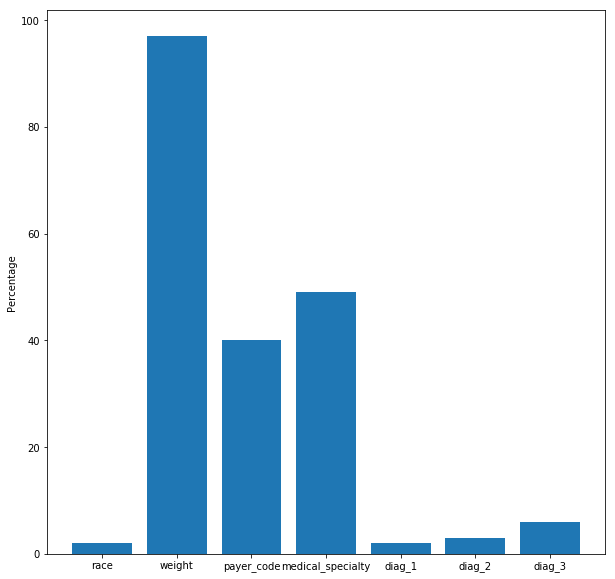

In [104]:
attributes = df.columns.values
print('Missing values:\n')
for attr in attributes:
    df[attr].replace('?', np.nan, inplace=True)
    df[attr].replace('', np.nan, inplace=True)
    df[attr].replace(r'[V|E][\d]+', np.nan, regex=True, inplace=True)
    
report_missing_values(df)
df[['diag_1', 'diag_2', 'diag_3']] = df[['diag_1', 'diag_2', 'diag_3']].astype(float)

In [105]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Show statistics of the dataset

In [106]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


### Drop columns
Drop attributes like IDs and other irrelevant attributes. The values of all medicines columns are consolidated into one column

In [107]:
redundant_features = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'admission_type_id', 
                'discharge_disposition_id', 'admission_source_id', 'number_outpatient', 'number_emergency', 
                'number_inpatient', 'examide', 
                'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'max_glu_serum', 
                'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
                'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton']
df.drop(redundant_features, inplace=True, axis =1)

In [108]:
def preprocess_diag(x):
    if x >= 240 and x <= 279:
        return 1
    else:
        return 0

### Replace missing values
Replace numerical missing values by their mean and categorical missing values by other categories

In [109]:
df['medical_specialty'] = df['medical_specialty'].replace([np.nan, ''], 'General')
df['race'] = df['race'].replace(np.nan, 'Other')

for attr in ['diag_1', 'diag_2', 'diag_3']:
    df[attr] = df[attr].replace(np.nan, 0)
    df[attr] = df[attr].apply(lambda x: preprocess_diag(x))

df['readmitted'] = df['readmitted'].replace(['<30'], 'YES')
df['readmitted'] = df['readmitted'].replace(['>30'], 'YES')
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,...,Female,Female,Female,Male,Female,Male,Female,Male,Female,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100),...,[60-70),[70-80),[80-90),[80-90),[60-70),[70-80),[80-90),[70-80),[80-90),[70-80)
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6
medical_specialty,Pediatrics-Endocrinology,General,General,General,General,General,General,General,General,InternalMedicine,...,General,General,General,General,General,General,General,General,Surgery-General,General
num_lab_procedures,41,59,11,44,51,31,70,73,68,33,...,46,21,76,1,45,51,33,53,45,13
num_procedures,0,0,5,1,0,6,1,0,2,3,...,6,1,1,0,1,0,3,0,2,3
num_medications,1,18,13,16,8,16,21,12,28,18,...,17,16,22,15,25,16,18,9,21,3
diag_1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
diag_2,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Print the unique value counts for readmitted
This is just to check if the dataset is balanced

In [110]:
df['readmitted'].value_counts()

NO     54864
YES    46902
Name: readmitted, dtype: int64

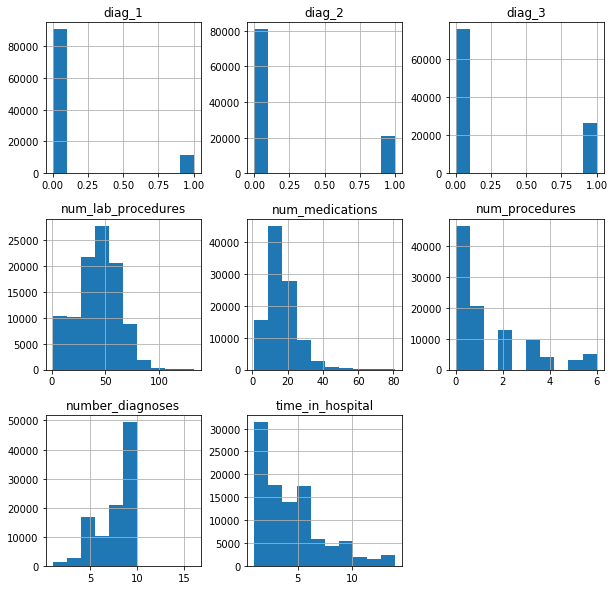

In [111]:
df.hist()
plt.show()

In [112]:
df.head()

,race,gender,age,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,insulin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),1,Pediatrics-Endocrinology,41,0,1,1,0,0,1,None,No,No,No,NO
1,Caucasian,Female,[10-20),3,General,59,0,18,1,1,1,9,None,Up,Ch,Yes,YES
2,AfricanAmerican,Female,[20-30),2,General,11,5,13,0,1,0,6,None,No,No,Yes,NO
3,Caucasian,Male,[30-40),2,General,44,1,16,0,1,0,7,None,Up,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,General,51,0,8,0,0,1,5,None,Steady,Ch,Yes,NO


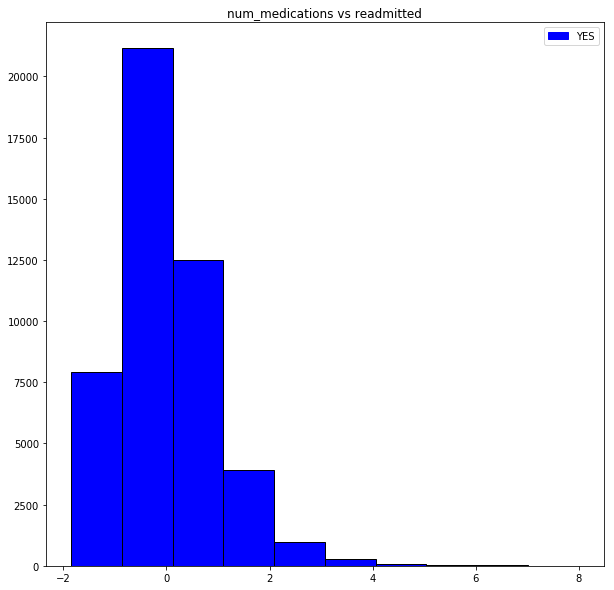

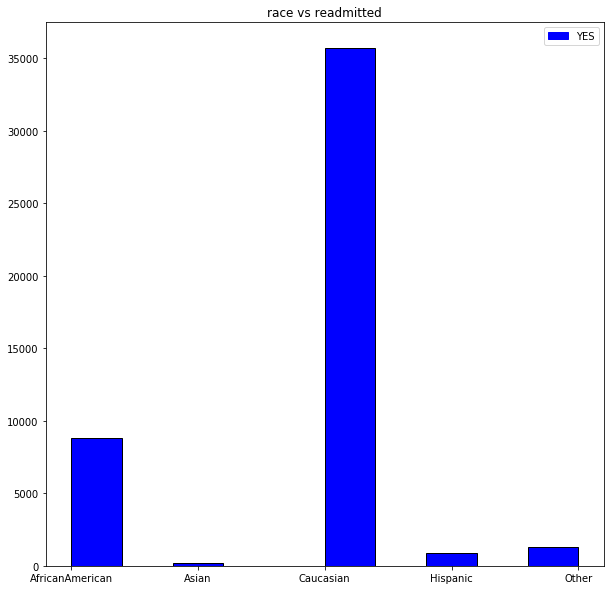

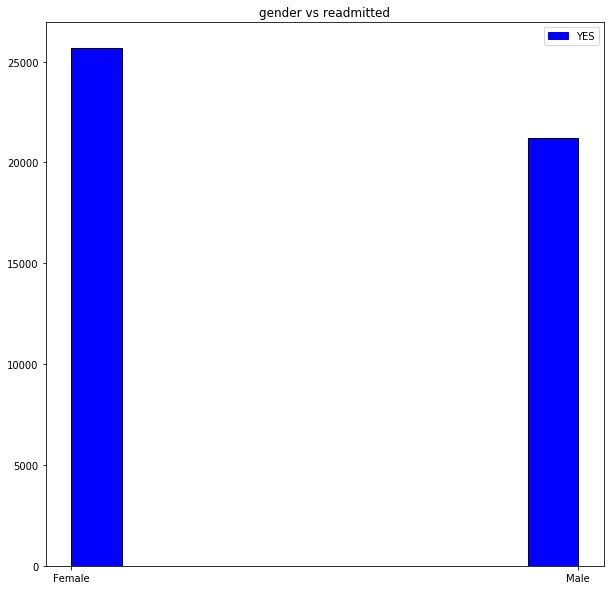

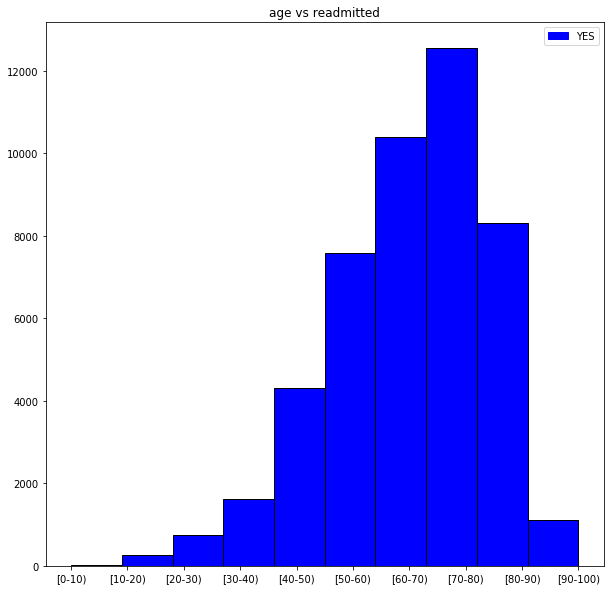

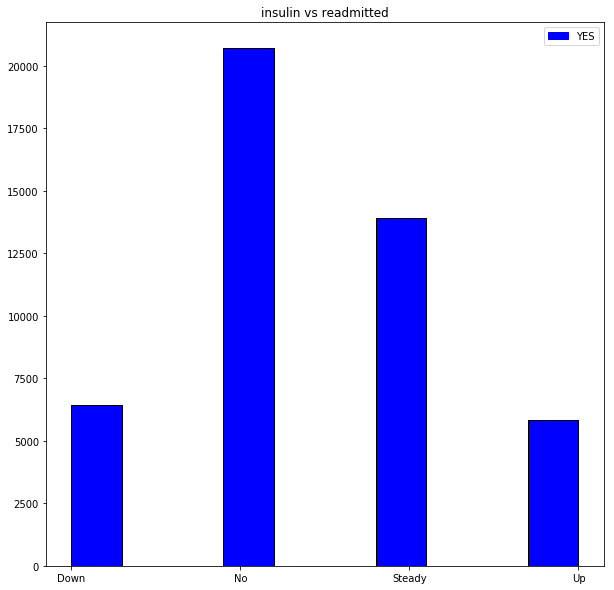

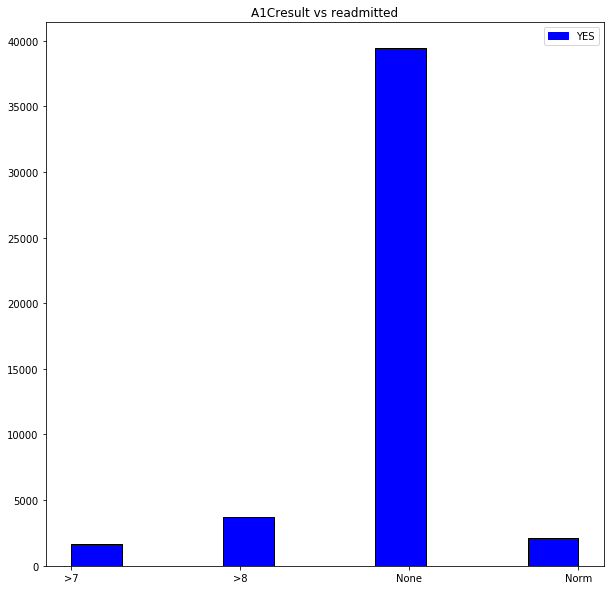

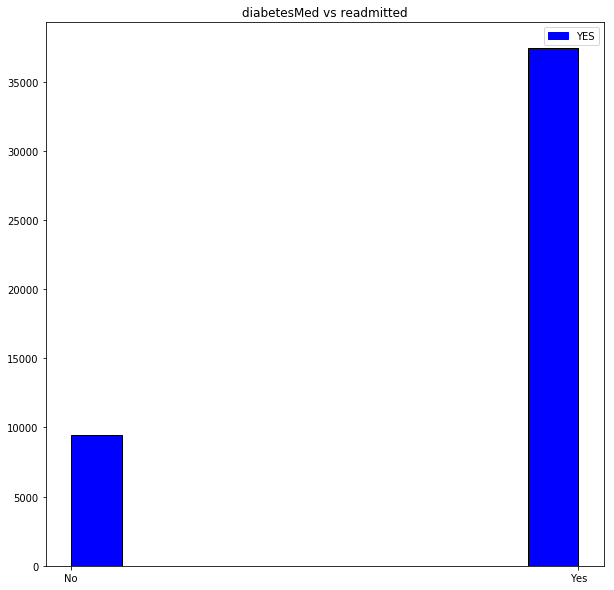

In [124]:
df_gb = df.groupby('readmitted')
gbs = [df_gb.get_group(x) for x in df_gb.groups]
legend_data =[('red', 'NO'), ('blue', 'YES')]


analyze_columns = ['num_medications', 'race', 'gender','age', 'insulin', 'A1Cresult' , 'diabetesMed' ]

for idx_outer, col in enumerate(analyze_columns):
    fig = plt.figure()
    title = analyze_columns[idx_outer] + ' vs readmitted'
    
    plt.title(title)
    patches = []
    for idx, gb in enumerate(gbs):
        
        if idx == 1:
            patches.append(mpatches.Patch(color=legend_data[idx][0], label=legend_data[idx][1]))
            plt.hist(gb[col].values, color=legend_data[idx][0], ec='black')
    plt.legend(handles=patches)
    plt.show()
    

## Scale values

In [114]:
attributes_to_scale= ['num_procedures', 'num_lab_procedures', 'num_medications', 'time_in_hospital']
scaler = StandardScaler(with_mean=False)
for attr in attributes_to_scale:
    df[attr] = (df[attr]-df[attr].mean()) / df[attr].std()

### Categorical to numeric
Perform one hot-shot encoding of the values since sci-kit learn doesn't handle categorical values

In [115]:
dummy_columns = ['race', 'gender','age', 'insulin', 'medical_specialty', 'A1Cresult' , 'diabetesMed' ]
df_dummies = pd.get_dummies(df, columns=dummy_columns)

df_dummies['readmitted'] = pd.Categorical(df_dummies['readmitted']).codes
df_target = df_dummies['readmitted']

# Drop the target variable from dataframe
df_dummies.drop('readmitted' , inplace = True, axis =1)
df_attr = df_dummies

# Concvert binary categorical values to numeric

df_attr['change'] = pd.Categorical(df_attr['change']).codes

df_attr.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,change,race_AfricanAmerican,...,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,diabetesMed_No,diabetesMed_Yes
0,-1.137643,-0.106516,-0.785394,-1.848259,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
1,-0.467650,0.808380,-0.785394,0.243388,1,1,1,9,0,0,...,0,0,0,0,0,0,1,0,0,1
2,-0.802647,-1.631343,2.145770,-0.371802,0,1,0,6,1,1,...,0,0,0,0,0,0,1,0,0,1
3,-0.802647,0.045966,-0.199161,-0.002688,0,1,0,7,0,0,...,0,0,0,0,0,0,1,0,0,1
4,-1.137643,0.401759,-0.785394,-0.986992,0,0,1,5,0,0,...,0,0,0,0,0,0,1,0,0,1


### Split attribues for training and testing
Split values for training and testing and apply PCA for feature selection


In [116]:
attr_train, attr_test, target_train, target_test = train_test_split(df_attr , df_target)

### Models
Fit various models and check results

In [117]:
models = [('Decision Tree', DecisionTreeClassifier(max_depth= 5), 'red'), 
          ('Logistic Regression', LogisticRegression(), 'green'), 
          ('Random Forest', RandomForestClassifier(), 'yellow'),
          ('Adaboost', AdaBoostClassifier(), 'magenta'),
          ('Neural Network', MLPClassifier(hidden_layer_sizes = 8,  max_iter= 500), 'blue')]
         

predicted_results = {}
time_elapsed = []
cross_val_list = []
for model_name, model, _ in models:
    
    start = time.time()    
    model.fit(attr_train, target_train)
    target_predict = model.predict(attr_test)
    
    score = cross_val_score(model, df_attr, df_target, cv=5)
    cross_val_list.append(score)
      
    end = time.time()
    
    time_elapsed.append(end - start)
    predicted_results[model_name] = target_predict

In [118]:
# for key, value in predicted_results.items():
#     print_bold(key)
#     print(itemfreq(value))

### Results
Show the results of various models

In [119]:
fpr_list = []
tpr_list = []
confusion_matrix_list = []

cm_values_list = []

for idx, (model_name, model, _) in enumerate(models):
    
    print_bold(model_name)
    print_bold('Accuracy Score')
    print(cross_val_list[idx].mean(), end='\n\n')
    
    print_bold('Time taken')
    print(round(time_elapsed[idx], 3) , 'ms')
    
    display_confusion_matrix(target_test.values, predicted_results[model_name])
    cm = confusion_matrix(target_test, predicted_results[model_name])
    confusion_matrix_list.append(cm)
    
    print_bold('Classification Report')
    print(classification_report(target_test, predicted_results[model_name]))

**Decision Tree**

**Accuracy Score**

0.556128465959



**Time taken**

2.908 ms


**Confusion Matrix**

Predicted      0     1
Actual                
0          10637  3053
1           8031  3721


**Classification Report**

             precision    recall  f1-score   support

          0       0.57      0.78      0.66     13690
          1       0.55      0.32      0.40     11752

avg / total       0.56      0.56      0.54     25442



**Logistic Regression**

**Accuracy Score**

0.56567997181



**Time taken**

12.563 ms


**Confusion Matrix**

Predicted     0     1
Actual               
0          9402  4288
1          6584  5168


**Classification Report**

             precision    recall  f1-score   support

          0       0.59      0.69      0.63     13690
          1       0.55      0.44      0.49     11752

avg / total       0.57      0.57      0.57     25442



**Random Forest**

**Accuracy Score**

0.546980209773



**Time taken**

12.111 ms


**Confusion Matrix**

Predicted     0     1
Actual               
0          9570  4120
1          7310  4442


**Classification Report**

             precision    recall  f1-score   support

          0       0.57      0.70      0.63     13690
          1       0.52      0.38      0.44     11752

avg / total       0.54      0.55      0.54     25442



**Adaboost**

**Accuracy Score**

0.568372443788



**Time taken**

21.337 ms


**Confusion Matrix**

Predicted     0     1
Actual               
0          9259  4431
1          6294  5458


**Classification Report**

             precision    recall  f1-score   support

          0       0.60      0.68      0.63     13690
          1       0.55      0.46      0.50     11752

avg / total       0.58      0.58      0.57     25442



**Neural Network**

**Accuracy Score**

0.573059778177



**Time taken**

32.276 ms


**Confusion Matrix**

Predicted     0     1
Actual               
0          8645  5045
1          5608  6144


**Classification Report**

             precision    recall  f1-score   support

          0       0.61      0.63      0.62     13690
          1       0.55      0.52      0.54     11752

avg / total       0.58      0.58      0.58     25442



### Analysis

            Model Name True Positive Rate False Positive Rate
0        Decision Tree               0.32                0.22
1  Logistic Regression               0.44                0.31
2        Random Forest               0.38                0.30
3             Adaboost               0.46                0.32
4       Neural Network               0.52                0.37


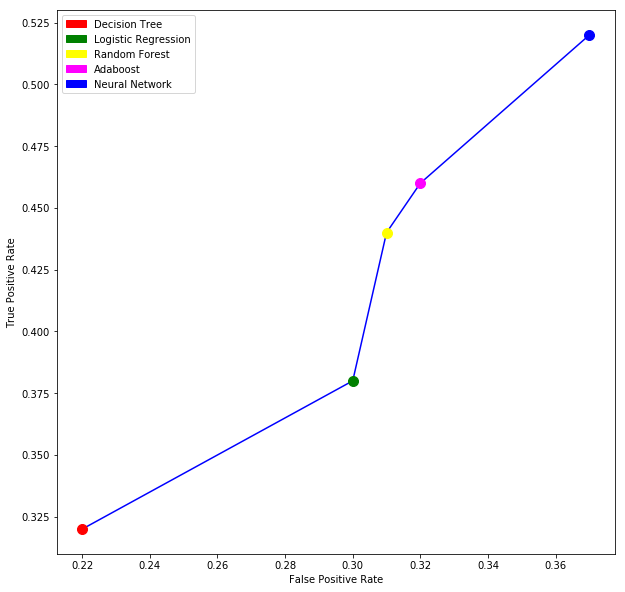

In [120]:
plot_roc_curve(confusion_matrix_list, models, 'False Positive Rate', 'True Positive Rate')